# Play against the transformer

With this notebook you can play against a transformer model that has been trained to predict moves of millions of tournament games. It uses no look-ahead so it definitely has tactical weaknesses.

Your moves are entered as four char combinations that encode starting square and target square, with the letter and number combinations that are written on the lower edge and the left side of the board. 

Castling is given by the king move, for example e1g1 or e1c1. Pawn promotion is signified by an additional letter for the piece the pawn is turned into, for example e7e8q for a queen or c7c8n for a knight. 

In [1]:
from tensorflow import keras
import chess
import chess.pgn
import chess.svg
import time
import numpy as np
from IPython.display import SVG, display, clear_output

In [2]:
model = keras.models.load_model('ChessTransformer_2.6')

In [3]:
column_numbers = {
    'a':1,
    'b':2,
    'c':3,
    'd':4,
    'e':5,
    'f':6,
    'g':7,
    'h':8
}

columns = 'abcdefgh'
rows = '12345678'
squares = []
for c in columns:
    for r in rows:
        squares.append(''.join([c,r]))
        
square_pairs = []
for sq1 in squares:
    for sq2 in squares:
        square_pairs.append(''.join([sq1,sq2]))

index2moves = []  # ['0-0','0-0-0'] Rochade ist e1g1 etc.
for pair in square_pairs:
    if pair[0:2]!=pair[2:]: 
        if pair[0] == pair[2]: # gerade hoch
            index2moves.append(pair)
        if pair[1] == pair[3]:  # gerade seitwärts
            index2moves.append(pair)
        if abs(int(pair[1])-int(pair[3])) == abs(column_numbers[pair[0]]-column_numbers[pair[2]]): #diagonal
            index2moves.append(pair)
        if abs(int(pair[1])-int(pair[3])) == 1 and abs(column_numbers[pair[0]]-column_numbers[pair[2]])==2: # Springer
            index2moves.append(pair)
        if abs(int(pair[1])-int(pair[3])) == 2 and abs(column_numbers[pair[0]]-column_numbers[pair[2]])==1: # Springer
            index2moves.append(pair)
        
        if (pair[3]=='8' and pair[1]=='7') or (pair[3]=='1' and pair[1]=='2'): # Umwandlungen
            if abs(column_numbers[pair[0]]-column_numbers[pair[2]])<=1:
                index2moves.append(pair+'q')
                index2moves.append(pair+'n')
                index2moves.append(pair+'b')
                index2moves.append(pair+'r')

index2moves = list(set(index2moves))
index2moves = sorted(index2moves)

move2label = {}
for i,move in enumerate(index2moves):
    move2label[move] = i

# Hier die pure-transformer 64*64 output version: In der Reihenfolge der Token, d.h. auch der FEN.
# output[startsquareindex][zielsquareindex] 
pure_square = {}
for row in range(8,0,-1):
    for column in 'abcdefgh':
        pure_square[column+str(row)] = len(pure_square)


# Tokenization of a chess position

token2piece = '0KkQqBbNnRrPp'

fen2token_dict = {
    'K':np.array([1]),
    'k':np.array([2]),
    'Q':np.array([3]),
    'q':np.array([4]),
    'B':np.array([5]),
    'b':np.array([6]),
    'N':np.array([7]),
    'n':np.array([8]),
    'R':np.array([9]),
    'r':np.array([10]),
    'P':np.array([11]),
    'p':np.array([12]),
    '1':np.array([0]),
    '2':np.array([0,0]),
    '3':np.array([0,0,0]),
    '4':np.array([0,0,0,0]),
    '5':np.array([0,0,0,0,0]),
    '6':np.array([0,0,0,0,0,0]),
    '7':np.array([0,0,0,0,0,0,0]),
    '8':np.array([0,0,0,0,0,0,0,0]),
    '/':np.array([]),
}

castling2token = {
    'KQkq':np.array([13,14,15,16]),
    'Qkq':np.array([0,14,15,16]),
    'Kkq':np.array([13,0,15,16]),
    'KQq':np.array([13,14,0,16]),
    'KQk':np.array([13,14,15,0]),
    'KQ':np.array([13,14,0,0]),
    'Kk':np.array([14,0,15,0]),
    'Kq':np.array([13,0,0,16]),
    'Qk':np.array([0,14,15,0]),
    'Qq':np.array([0,14,0,16]),
    'kq':np.array([0,0,15,16]),
    'K':np.array([13,0,0,0]),
    'Q':np.array([0,14,0,0]),
    'k':np.array([0,0,15,0]),
    'q':np.array([0,0,0,16]),
    '-':np.array([0,0,0,0]),
}

column2token = {
    'a':np.array([17]),
    'b':np.array([18]),
    'c':np.array([19]),
    'd':np.array([20]),
    'e':np.array([21]),
    'f':np.array([22]),
    'g':np.array([23]),
    'h':np.array([24]),
    '-':np.array([0])
}

color2token = {
    'w':np.array([25]),
    'b':np.array([26])
}

def elo2token(elo):
    if elo < 1500:
        token = 27
    elif elo>=2600:
        token = 37
    else:
        token = 27 + (elo-1500)//100
    return np.array([token])


    
def fen2token(fen):
    token_listen = []
    liste1 = fen.split()

    for l in liste1[0]:
        #print(l,fen2token_dict[l])
        token_listen.append(fen2token_dict[l])
    
    token_listen.append(color2token[liste1[1]]) # Wer am Zug ist
    
    token_listen.append(castling2token[liste1[2]]) # Rochaderechte
    
    token_listen.append(column2token[liste1[3][0]])  # en passant column
    
    # Außerdem gibt es noch Halbzüge seit Bauernzug/Schlagzug und Zug der Partie. Die lassen wir weg.
    
    tokens = np.concatenate(token_listen)
    tokens = tokens.reshape((1,-1))
    return tokens

In [4]:

def start_game():
    game = chess.pgn.Game()
    board = game.board()
    return board, game

def display_board(board):
    board_pic = chess.svg.board(board, size=350)
    clear_output(wait=True)
    display(board_pic)

def get_move_input(board):
    no_legal_move_yet = True
    while no_legal_move_yet:
        your_move = input('Your move:')
        no_legal_move_yet = False
        time.sleep(0.5)
        try:
            move = chess.Move.from_uci(your_move)
            if not (move in board.legal_moves):
                no_legal_move_yet = True
        except:
            no_legal_move_yet = True
            
        if no_legal_move_yet:
            print('Your move is not legal. Please try again.\nMoves given by the coordinates of start and target square: \nLike e1g1 or d1d8.')
    return move

def transformer_move(board, model):
    token = fen2token(board.fen())
    probabilities = model.predict(token)
    candidates = zip(probabilities[0],index2moves)
    candidates = sorted(candidates)[::-1]
    
    no_legal_move_yet = True
    index = 0
    time.sleep(1.0)
    while no_legal_move_yet:
        model_move = candidates[index][1]
        move = chess.Move.from_uci(model_move)
        no_legal_move_yet = False
        if not (move in board.legal_moves):
            no_legal_move_yet=True
            print('The model chose a illegal move ... it will try again.',candidates[index])
            time.sleep(1.0)
            index += 1
    return move, candidates

def play_game():
    board, game = start_game()
    display_board(board)
    all_moves = []
    while not board.is_game_over():
        # Dein Zug
        dein_move = get_move_input(board)
        board.push(dein_move)
        display_board(board)
        all_moves.append(dein_move)
        if board.is_game_over():
            break
        # Transformer Zug
        t_move, candidates = transformer_move(board, model)
        board.push(t_move)
        display_board(board)
        print(candidates[:5])
        all_moves.append(t_move)
    print("The game is over ",board.result())

    node = game
    for move in all_moves:
        node = node.add_variation(chess.Move.from_uci(move.uci()))
    exporter = chess.pgn.StringExporter(headers=True, variations=True, comments=True)
    pgn_string = game.accept(exporter)
    print(pgn_string)



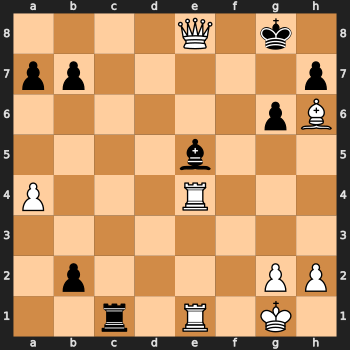

The game is over  1-0
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

1. e3 d5 2. f4 Nf6 3. Nf3 g6 4. d4 Bg7 5. Bd3 O-O 6. Nbd2 c5 7. c3 Nc6 8. O-O
cxd4 9. exd4 Bg4 10. Qe1 Qd6 11. Ne5 Bf5 12. Qe2 Bxd3 13. Qxd3 Rac8 14. a4 Nd7
15. Ndf3 f6 16. Nxd7 Qxd7 17. Re1 Rfe8 18. Bd2 e5 19. fxe5 fxe5 20. dxe5 Nxe5
21. Nxe5 Bxe5 22. Bh6 d4 23. Re4 dxc3 24. Qxd7 cxb2 25. Rae1 Rc1 26. Qxe8# *


In [5]:
play_game()